In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [2]:
plt.rcParams['axes.axisbelow'] = True

In [3]:
# Define constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10
NUM_CLASSES = 5

In [4]:
def load_data(folder_path):
    X = []
    y = []
    class_names = [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]
    print("Class names:", class_names)
    
    for i, class_name in enumerate(class_names):
        class_path = os.path.join(folder_path, class_name)
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            try:
                image = load_img(image_path, target_size=IMAGE_SIZE)
                image = img_to_array(image)
                X.append(image)
                y.append(i)
            except Exception as e:
                print(f"Error loading image {image_path}: {e}")
    X = np.array(X)
    y = np.array(y)
    return X, y

# Path to the folder containing flower images
folder_path = 'flower_photos'

# Load the data
X, y = load_data(folder_path)

Class names: ['roses', 'sunflowers', 'daisy', 'dandelion', 'tulips']


Labels distribution:
Class: 0 , Count: 641 , Perc :17.5%
Class: 1 , Count: 699 , Perc :19.0%
Class: 2 , Count: 633 , Perc :17.2%
Class: 3 , Count: 898 , Perc :24.5%
Class: 4 , Count: 799 , Perc :21.8%


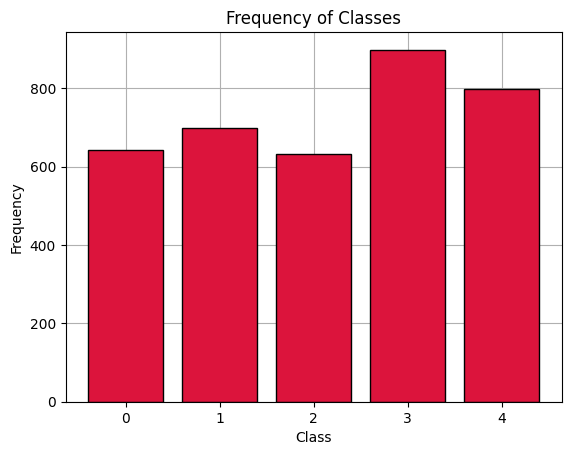

In [5]:
unique_classes, class_counts = np.unique(y, return_counts=True)

print('Labels distribution:')
for i in range(NUM_CLASSES):
    print('Class:', i, ', Count:', class_counts[i], ', Perc :{:.1f}%'.format(100*class_counts[i]/len(y)))

plt.bar(unique_classes, class_counts, edgecolor='black', color='crimson')
plt.title('Frequency of Classes')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(unique_classes)
plt.grid(True)
plt.show()

In [6]:
X_normalized = X/255.

In [7]:
from sklearn.model_selection import train_test_split

def split_data(X, y, train_size, val_size, test_size, random_state=None):
    """
    Splits data into train, validation, and test sets based on given sizes.

    Parameters:
    X (array-like): Features dataset.
    y (array-like): Labels dataset.
    train_size (float): Proportion of the dataset to include in the train split.
    val_size (float): Proportion of the dataset to include in the validation split.
    test_size (float): Proportion of the dataset to include in the test split.
    random_state (int, optional): Random seed for reproducibility.

    Returns:
    X_train, X_val, X_test, y_train, y_val, y_test: Split datasets.
    """
    
    if train_size + val_size + test_size != 1.0:
        raise ValueError("The sum of train_size, val_size, and test_size must be 1.0")

    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(val_size + test_size), random_state=random_state)
    
    remaining_proportion = val_size / (val_size + test_size)
    
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=(1 - remaining_proportion), random_state=random_state)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [8]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X_normalized, y, 
                                                            train_size=0.8, 
                                                            val_size=0.1, 
                                                            test_size=0.1, 
                                                            random_state=42)

In [9]:
# Train split
unique_classes_train, class_counts_train = np.unique(y_train, return_counts=True)
unique_classes_val, class_counts_val = np.unique(y_val, return_counts=True)
unique_classes_test, class_counts_test = np.unique(y_test, return_counts=True)

# Final plots

Train percentages per class: [76.59906396 80.40057225 80.4107425  81.51447661 80.35043805]
Val percentages per class: [11.85647426 10.30042918  9.00473934  9.35412027  9.76220275]
Test percentages per class: [11.54446178  9.29899857 10.58451817  9.13140312  9.8873592 ]


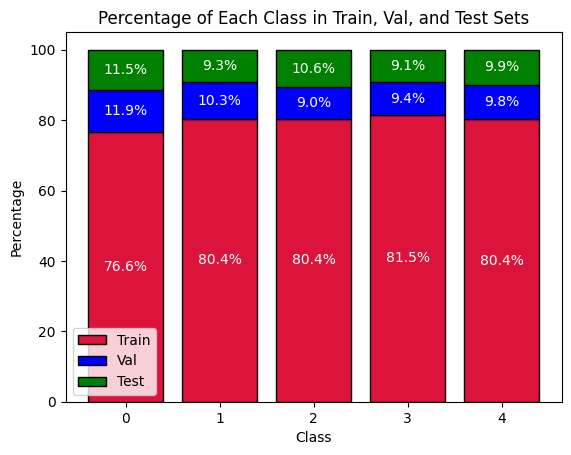

In [11]:
# Calculate the total counts for each class across all sets
total_counts_per_class = class_counts_train + class_counts_val + class_counts_test

# Normalize the counts to percentages for each class
percent_train = (class_counts_train / total_counts_per_class) * 100
percent_val = (class_counts_val / total_counts_per_class) * 100
percent_test = (class_counts_test / total_counts_per_class) * 100

# Create the initial bar for the training set
bars_train = plt.bar(unique_classes, percent_train, edgecolor='black', color='crimson', label='Train')

# Add the validation set on top of the training set
bars_val = plt.bar(unique_classes, percent_val, bottom=percent_train, edgecolor='black', color='blue', label='Val')

# Calculate the cumulative percentages for the training and validation sets
cumulative_percent = percent_train + percent_val

# Add the test set on top of the training and validation sets
bars_test = plt.bar(unique_classes, percent_test, bottom=cumulative_percent, edgecolor='black', color='green', label='Test')

# Add text labels to the bars
for bar in bars_train:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height / 2.0, f'{height:.1f}%', ha='center', va='center', color='white')

for bar, bottom in zip(bars_val, percent_train):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, bottom + height / 2.0, f'{height:.1f}%', ha='center', va='center', color='white')

for bar, bottom in zip(bars_test, cumulative_percent):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, bottom + height / 2.0, f'{height:.1f}%', ha='center', va='center', color='white')

# Print the percentages
print("Train percentages per class:", percent_train)
print("Val percentages per class:", percent_val)
print("Test percentages per class:", percent_test)

# Add labels and title
plt.title('Percentage of Each Class in Train, Val, and Test Sets')
plt.xlabel('Class')
plt.ylabel('Percentage')
plt.xticks(unique_classes)
plt.legend()
plt.show()

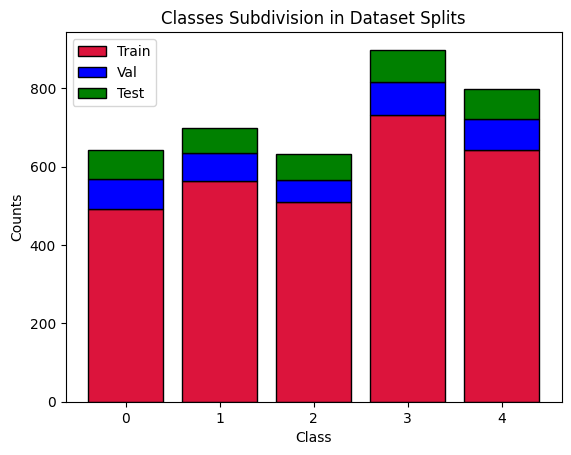

In [12]:
# Calculate the cumulative heights for the training and validation sets
cumulative_counts = np.array(class_counts_train) + np.array(class_counts_val)

plt.bar(unique_classes_train, class_counts_train, edgecolor='black', color='crimson',label='Train')
plt.bar(unique_classes_val, class_counts_val, bottom=class_counts_train, edgecolor='black', color='blue',label='Val')
plt.bar(unique_classes_test, class_counts_test, bottom=cumulative_counts, edgecolor='black', color='green',label='Test')
plt.title('Classes Subdivision in Dataset Splits')
plt.xlabel('Class')
plt.ylabel('Counts')
plt.xticks(unique_classes)
plt.legend()
plt.show()